# 연관 분석

## 공통 코드

In [1]:
# 파이썬
# ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# 이미지를 저장할 디렉토리 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

# 이미지 저장
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
    
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

# 그래픽 출력을 좀 더 고급화하기 위한 라이브러리
import seaborn as sns

# 과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
# 0.20 이상 버전에서 데이터 변환을 위한 Transformer 클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해 시드 고정
# 데이터를 분할할 때 동일한 분할을 만들어 냄
np.random.seed(21)

## 행렬 분해를 이용한 잠재 요인 협업 추천 알고리즘 구현

### 평가 지표를 계산하는 함수

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 원래 데이터를 행렬 분해한 데이터를 복원한 데이터와 비교해서
# 차이를 구해주는 함수
# P와 Q는 행렬 분해가 된 데이터들이고
# non_zeros 는 0이 아닌 데이터의 인덱스
def get_rmse(R, P, Q, non_zeros):
    error = 0
    
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    # 행렬 분해되어 있던 데이터를 원래 행렬로 복원
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 
    # 실제 R 행렬과 예측 행렬의 RMSE 추출
    
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    
    # 복원된 데이터와 원래의 데이터를 가지고 mse 를 계산
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [37]:
# 행렬 분해 함수
# 실제 딥러닝 모델에서는 이미 구현이 되어 있어서 필요 x
# steps 는 반복 횟수, learning_rate 는 학습률,
# r_lambda 는 정규화에 사용할 가중치 값
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(21)
    
     # item 이 영화에 해당
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))
    
    # 중간에 멈춘 갯수 파악
    break_count = 0
    
    # 행렬에서 값이 0이 아닌 데이터의 인덱스 리스트를 생성
    # 유저와 영화를 순회하는데 그 평점이 0이 아닌 경우를 가져옴
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]
    
    # steps 횟수만큼 가중치를 수정(업데인트) 하면서 학습
    # rmse 는 계속 작아지게 됨 
    # 이론상 0으로 만들 수 있지만 0이 되면 과적합
    # 원래 값인 r 에서 인덱스 i, j 를 활용해서 빼기 적용하면서 rmse 가 작아지도록 만듦
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            
            # Regularization을 반영한 SGD 업데이트 공식 적용
            # 학습률에 따라 P와 Q를 수정
            # 계산의 결과로 나온 오류를 가지고 다시 행렬을 바꾸는 가중치 업데이트
            # 이를 역전파라고 함
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
            
        rmse = get_rmse(R, P, Q, non_zeros)
        # 10번 반복마다 rmse 를 출력해서 개선되는지 파악
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

In [35]:
# 행렬 분해를 적용할 데이터 가져오기

movies = pd.read_csv('./data/movielens/movies.csv')
ratings = pd.read_csv('./data/movielens/ratings.csv')
#movies.info()
#ratings.info()

# 데이터 생성 - ratings 에서 timestamp 는 필요하지 않음
ratings = ratings[['userId', 'movieId', 'rating']]

# 영화 제목과 평점을 하나의 테이블로 만들기 - 조인(merge)
ratings_movies = pd.merge(ratings, movies, on = 'movieId')
#ratings_movies.info()

# 개인화된 추천을 하기 위해서는 인덱스를 userId 로, 
# 컬럼을 title 로, rating 을 계산 항목으로 테이블을 수정해줘야 함
# 여기에 피봇 테이블을 적용해서 수정
ratings_matrix = ratings_movies.pivot_table('rating', index = 'userId',
                                           columns = 'title')
#print(ratings_matrix.head())
print(ratings_matrix.shape)
# 이런 형태의 데이터를 구성하는게 중요


(610, 9719)


In [38]:
# 행렬 분해를 수행
# k 는 스케일의 크기 조절, r_lambda 는 가중치 조절용
P, Q = matrix_factorization(ratings_matrix.values, K = 50,
                           steps = 200, learning_rate = 0.01,
                           r_lambda = 0.01)

# 분해한 행렬을 가지고 복원
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.912217128099324
### iteration step :  10  rmse :  0.7310566902274522
### iteration step :  20  rmse :  0.5118355467473588
### iteration step :  30  rmse :  0.37120685396697334
### iteration step :  40  rmse :  0.2940549289560331
### iteration step :  50  rmse :  0.2503604719049737
### iteration step :  60  rmse :  0.2236028492297467
### iteration step :  70  rmse :  0.20592649435756755
### iteration step :  80  rmse :  0.19346705309015938
### iteration step :  90  rmse :  0.18421806764249074
### iteration step :  100  rmse :  0.17707410057265577
### iteration step :  110  rmse :  0.17138598775361324
### iteration step :  120  rmse :  0.16674861731177684
### iteration step :  130  rmse :  0.16289563965894346
### iteration step :  140  rmse :  0.15964429710826877
### iteration step :  150  rmse :  0.15686474487038674
### iteration step :  160  rmse :  0.15446203226794716
### iteration step :  170  rmse :  0.15236501703006228
### iteration step :  180  r

In [39]:
# 연산 결과 확인 - 인덱스와 컬럼 없이 숫자(ndarray)만 존재함
print(pred_matrix)

[[2.897 4.263 3.716 ... 2.396 3.945 0.825]
 [3.11  3.793 3.338 ... 1.757 4.536 0.836]
 [2.275 1.837 1.566 ... 0.729 1.457 0.378]
 ...
 [2.222 2.97  2.64  ... 1.918 2.472 0.587]
 [2.632 3.387 2.941 ... 1.607 3.575 0.681]
 [3.953 3.804 3.291 ... 1.521 3.264 0.778]]


In [42]:
# 행렬 분해를 한 후 복원한 결과를 DataFrame 으로 변환
# 컬럼과 인덱스에 이름을 부여
ratings_pred_matrix = pd.DataFrame(data = pred_matrix, 
                                   index = ratings_matrix.index,
                                  columns = ratings_matrix.columns)
# 확인
#print(ratings_pred_matrix)

In [49]:
# 유저가 보지 않은 영화 목록을 리턴하는 함수
# 일반적으로 이미 본 영화는 추천하지 않음
def get_unseen_movies(ratings_matrix, userId):
    # 유저 id를 가지고 평점 정보 가져오기
    user_rating = ratings_matrix.loc[userId, :]
    
    # 평점이 0을 초과하는 데이터는 이미 본 영화들임
    # 해당하는 영화들의 인덱스를 리스트로 가져옴
    already_seen_movies = user_rating[user_rating > 0].index.tolist()
    
    # 이미 본 영화 리스트에 포함되는 영화를 제외하고 리스트를 가져옴
    movies_list = ratings_matrix.columns.tolist()
    unseen_movies_list = [movie for movie in movies_list if movie not in already_seen_movies]
    
    return unseen_movies_list

In [51]:
# 아직 보지 않은 영화 중에서 평점이 높은 순으로 정렬해서 리턴하는 함수
def recommend_movie_by_userid(pred_df, userid, unseen_movies_list, top_n = 10):
    recommend_movies = pred_df.loc[userid, 
                                   unseen_movies_list].sort_values(ascending = False)[:top_n]
    
    return recommend_movies

In [53]:
# 12번 유저가 보지 않은 영화 목록 만들기
unseen_movie_list = get_unseen_movies(ratings_matrix, 12)
recommend_unseen_movies = recommend_movie_by_userid(ratings_pred_matrix, 
                                            12, unseen_movie_list, top_n = 10)
print(recommend_unseen_movies)

title
Gladiator (2000)                               6.113919
Field of Dreams (1989)                         6.108903
Dead Poets Society (1989)                      5.907838
American President, The (1995)                 5.798334
Amadeus (1984)                                 5.783868
Devil Wears Prada, The (2006)                  5.767490
Patton (1970)                                  5.745500
Remember the Titans (2000)                     5.714263
My Life as a Dog (Mitt liv som hund) (1985)    5.662781
Crash (2004)                                   5.614942
Name: 12, dtype: float64


## surprise 패키지 활용

In [54]:
!pip install scikit_surprise

     -------------------------------------- 772.0/772.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit_surprise: filename=scikit_surprise-1.1.3-cp310-cp310-win_amd64.whl size=1082374 sha256=af4c13455455910b90168dc296da17097e15cd256fdaacfd1783af90e7fa8c77
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\df\e4\a6\7ad72453dd693f420b0c639bedeec34641738d11b55d8d9b84
Successfully built scikit_surprise


In [58]:
# surprise 패키지는 다양한 기능을 보유하고 있음
import surprise
from surprise import SVD, Dataset, accuracy 
from surprise.model_selection import train_test_split

data = Dataset.load_builtin(name = 'ml-100k', prompt = True)
print(type(data))
print(data)

<class 'surprise.dataset.DatasetAutoFolds'>


In [59]:
train_data, test_data = train_test_split(data, test_size = 0.2,
                                        random_state = 21)
print(type(train_data)) # surprise.trainset.Trainset
print(type(test_data)) # list

<class 'surprise.trainset.Trainset'>
<class 'list'>


In [76]:
print(train_data)
print(test_data[:5]) # UserId, itemId, rating 순서로 데이터 보유
#print(test_data.pop()) # tuple 의 list 형태이므로 pop 이 가능

[('453', '234', 3.0), ('900', '205', 4.0), ('466', '231', 1.0), ('506', '742', 5.0), ('860', '1602', 3.0)]


In [77]:
# SVD 를 만들 필요 없이 가져와서 사용 가능
algo = SVD()
algo.fit(train_data)

# 예측
preds = algo.test(test_data)
#print(preds[:5]) # tuple 의 list 형태

print([(pred.uid, pred.iid, pred.est) for pred in preds[:5]])

[('453', '234', 3.7828753429738544), ('900', '205', 3.09255898454824), ('466', '231', 2.533811739275344), ('506', '742', 4.1406183264314755), ('860', '1602', 3.3223136643803746)]


In [78]:
# 임의의 userid 와 itemid 를 가지고 평점을 예측
uid = str(1234)
iid = str(234)
pred = algo.predict(uid, iid)
print(pred) # 예측 평점은 3.84

user: 1234       item: 234        r_ui = None   est = 3.84   {'was_impossible': False}


## 로컬 데이터를 이용한 surprise 패키지 활용

In [84]:
# 데이터 읽어오기
from surprise import Reader

ratings = pd.read_csv('./data/movielens/ratings.csv')
#print(ratings.head())

# 데이터의 구조를 변경하기위해 헤더를 제거하고 파일로 저장
ratings.to_csv('./data/movielens/ratings_no_header.csv', index = False,
               header = False)

# 파일 다시 읽어오기
ratings = pd.read_csv('./data/movielens/ratings_no_header.csv')
print(ratings.head())

   1  1.1  4.0  964982703
0  1    3  4.0  964981247
1  1    6  4.0  964982224
2  1   47  5.0  964983815
3  1   50  5.0  964982931
4  1   70  3.0  964982400


In [91]:
# 변경된 포멧의 데이터 읽어오기

# 읽어올 방식 지정
reader = Reader(line_format = 'user item rating timestamp', sep = ',',
               rating_scale = (0.5, 5))
# 데이터를 읽어올 파일과 읽을 방식을 지정
data = Dataset.load_from_file('./data/movielens/ratings_no_header.csv',
                             reader = reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [95]:
train_data, test_data = train_test_split(data, test_size = 0.2,
                                        random_state = 21)
algo = SVD(n_factors = 50, random_state = 21)
algo.fit(train_data)

preds = algo.test(test_data)

accu = accuracy.rmse(preds)
print(accu)

RMSE: 0.8724
0.8723955003620125


In [99]:
# 교차 검증
from surprise.model_selection import cross_validate


# 데이터 읽어오기
ratings = pd.read_csv('./data/movielens/ratings.csv')
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId',
                                    'rating']], reader)

# 교차 검증 수행

algo = SVD(random_state = 21)
# 평점 예측도 회귀의 일종이기에
# 평가 지표로 RMSE, MAE 를 활용함
cross_validate(algo, data, measures = ['RMSE', 'MAE'],
              cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8692  0.8701  0.8744  0.8693  0.8801  0.8726  0.0042  
MAE (testset)     0.6654  0.6679  0.6710  0.6717  0.6772  0.6706  0.0040  
Fit time          0.53    0.54    0.53    0.53    0.54    0.53    0.00    
Test time         0.06    0.18    0.06    0.06    0.06    0.09    0.05    


{'test_rmse': array([0.869, 0.87 , 0.874, 0.869, 0.88 ]),
 'test_mae': array([0.665, 0.668, 0.671, 0.672, 0.677]),
 'fit_time': (0.534, 0.537, 0.532, 0.530, 0.538),
 'test_time': (0.059, 0.181, 0.064, 0.064, 0.063)}

In [106]:
# 하이퍼 파라미터 튜닝 - 입력 파라미터의 최적을 찾는 작업
from surprise.model_selection import GridSearchCV

# 파라미터 지정
# epochs 는 반복 횟수, factors 는 열의 갯수
param_grid = {'n_epochs' : [10, 20, 40, 60], 
              'n_factors' : [50, 100, 150, 200]}

# 위의 파라미터를 가지고 조합해서 수행
gs = GridSearchCV(SVD, param_grid, measures = ['RMSE', 'MAE'], cv = 5)
gs.fit(data)

print(gs.best_score['rmse'])

0.8706403212084444


In [107]:
# 최적의 파라미터 확인
print(gs.best_params['rmse'])

{'n_epochs': 20, 'n_factors': 50}


## 상품 추천

In [116]:
# 데이터 읽어오기
# ID 의 경우 숫자 형식이지만 숫자 자료형으로 다루지 않으므로
# 데이터를 읽어올 때 자료형을 변경
df = pd.read_csv('./data/online_retail.csv', encoding = 'latin',
                dtype = {'CustomerID' : str, 'InvoiceNo' : str})
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [119]:
# 날짜를 저장하고 있는 InvoiceDate 를 수정
# 연/월/일/수/분/초 형식으로 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], 
                                   format = '%m/%d/%Y %H:%M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [120]:
# 데이터의 결측치 확인
# null 이 아니면 False, null 이면 True 가 되는데
# True 는 1로 볼 수 있으므로 sum() 을 적용하면 
# 갯수를 셀 수 있음
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [121]:
# 결측 데이터 제거 - dropna
df = df.dropna()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [124]:
# 이상 데이터 처리
# 데이터에서 Quantity, UnitPrice 를 확인해봐야 함

print((df['Quantity'] < 0).sum())
# Quantity 의 경우 음수가 있을 수 없는데 8905개가 존재

# Quantity 가 0 이상인 데이터만 가져오고 나머지 삭제
df = df[df['Quantity'] >= 0]
print((df['Quantity'] < 0).sum())

8905
0


In [126]:
# UnitPrice 가 0보다 작은 경우 삭제

print((df['UnitPrice'] < 0).sum())
df = df[df['UnitPrice'] >= 0]
print((df['UnitPrice'] < 0).sum())

0
0


In [129]:
# 상품 코드 데이터 확인
# 상품 코드에 숫자가 아닌 값이 포함된 경우를 모두 찾기
df['ContainDigit'] = df['StockCode'].apply(lambda x : any(c.isdigit() for c in x))
#print(df[df['ContainDigit'] == False].sum())

# 모두 숫자인 조건에 True 인 데이터만 가져오기
df = df[df['ContainDigit'] == True]
print(df[df['ContainDigit'] == False].sum())

InvoiceNo       5363705364035365275365695365695367795368405368...
StockCode       POSTPOSTPOSTMMBANK CHARGESPOSTPOSTPOSTPOSTPOST...
Description     POSTAGEPOSTAGEPOSTAGEManualManualBank ChargesP...
Quantity                                                    10331
UnitPrice                                               96550.134
CustomerID      1258312791126621627416274158231273812686135201...
Country         FranceNetherlandsGermanyUnited KingdomUnited K...
ContainDigit                                                    0
dtype: object
InvoiceNo       0.0
StockCode       0.0
Description     0.0
Quantity        0.0
UnitPrice       0.0
CustomerID      0.0
Country         0.0
ContainDigit    0.0
dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_6664\3197771797.py:4: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[df['ContainDigit'] == False].sum())
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\3197771797.py:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[df['ContainDigit'] == False].sum())


<Axes: xlabel='InvoiceDate'>

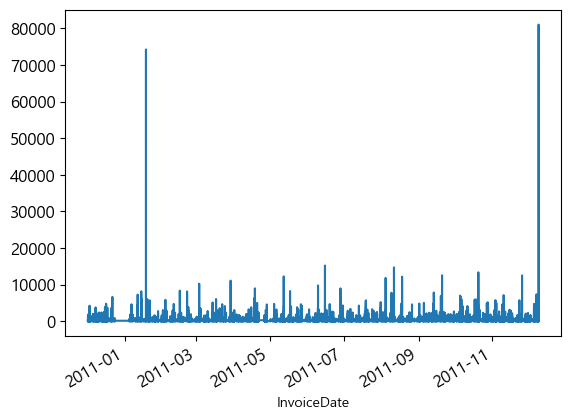

In [131]:
# 일자별 거래 수량 확인
# 날짜를 기준으로 groupby 를 해서 그 날의 Quantity 에 대해 sum
data_quantity_series = df.groupby('InvoiceDate')['Quantity'].sum()
data_quantity_series.plot()

<Axes: xlabel='InvoiceDate'>

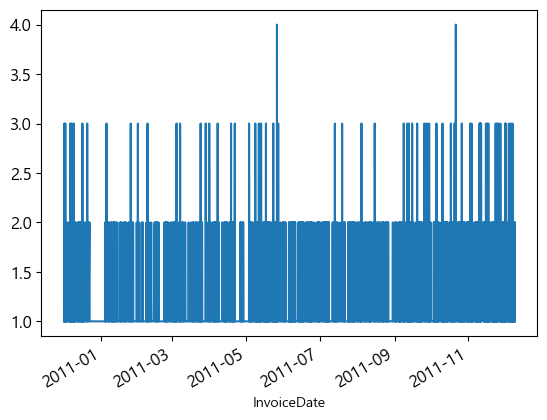

In [132]:
# 일자별 거래 건수 확인
data_transaction_series = df.groupby('InvoiceDate')['InvoiceNo'].nunique()
data_transaction_series.plot()

<Axes: xlabel='InvoiceDate'>

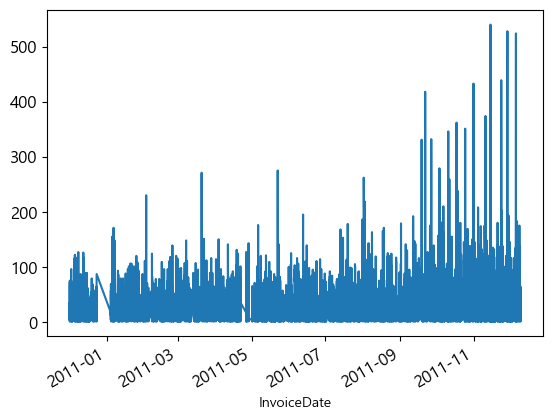

In [133]:
# 일자별 거래 물품의 종류 확인

data_unique_item_series = df.groupby('InvoiceDate')['StockCode'].nunique()
data_unique_item_series.plot()

Text(0.5, 1.0, '일자별 물품 종류')

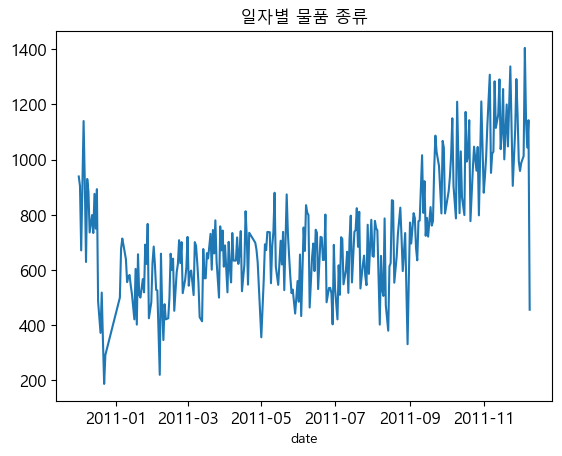

In [139]:
# 일자별 데이터가 시, 분, 초 단위까지 구성되어 있으므로
# 날짜 이상의 단위만 남겨서 간격을 넓게 만들어서 확인
df['date'] = df['InvoiceDate'].dt.date

data_unique_item_series = df.groupby('date')['StockCode'].nunique()
data_unique_item_series.plot()
plt.title('일자별 물품 종류')

<Axes: xlabel='date'>

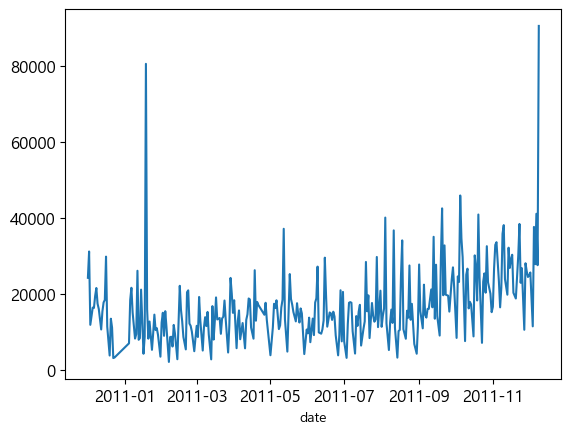

In [137]:
data_quantity_series = df.groupby('date')['Quantity'].sum()
data_quantity_series.plot()

<Axes: xlabel='date'>

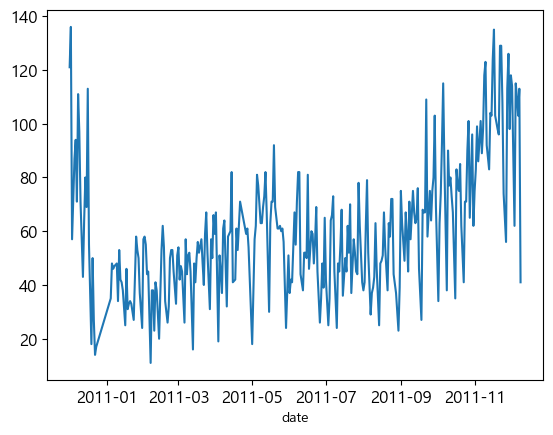

In [141]:
# 일자별 거래 건수 확인
data_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
data_transaction_series.plot()

In [140]:
# 거래 일자의 범위 확인
print(df['date'].min(), df['date'].max())

2010-12-01 2011-12-09


In [145]:
# 유저별 거래 횟수 탐색
# 유저 id 별로 묶어서 거래 번호(InvoiceNo)의 수를 카운트
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4335.000000
mean        4.246367
std         7.643880
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

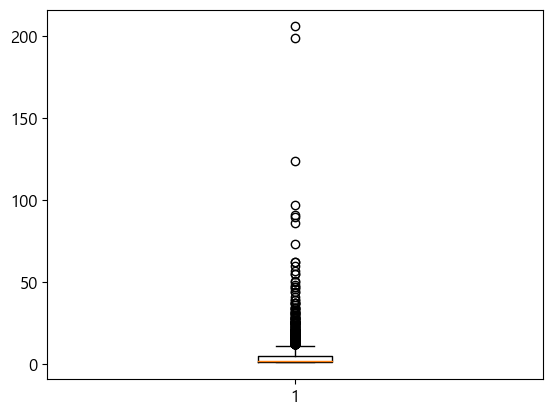

In [146]:
# 유저별 거래 횟수를 boxplot 으로 나타내기
plt.boxplot(customer_unique_transaction_series.values)
plt.show()
# 특정 유저가 매우 많은 횟수를 나타내는데
# 이를 단순하게 이상치로 판단하고 삭제하면 안 됨

In [149]:
# 유저 별로 거래한 아이템의 종류의 수를 탐색
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4335.000000
mean       61.419839
std        85.309669
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

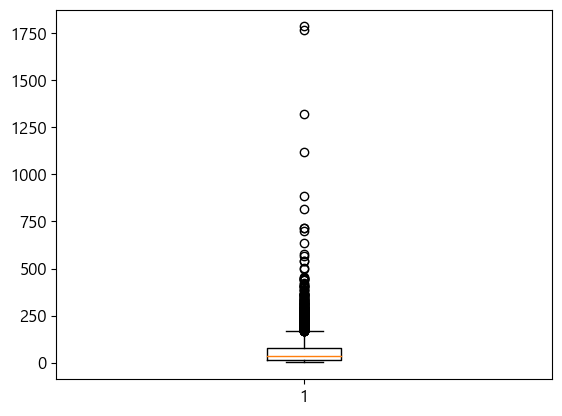

In [150]:
# 유저별 아이템의 종류의 수를 boxplot 으로 나타내기
plt.boxplot(customer_unique_item_series.values)
plt.show()

In [151]:
# 거래가 가장 많은 상품 탐색 - 상위 10개
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending = False)[:10]

StockCode
85123A    1978
22423     1704
85099B    1600
47566     1380
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

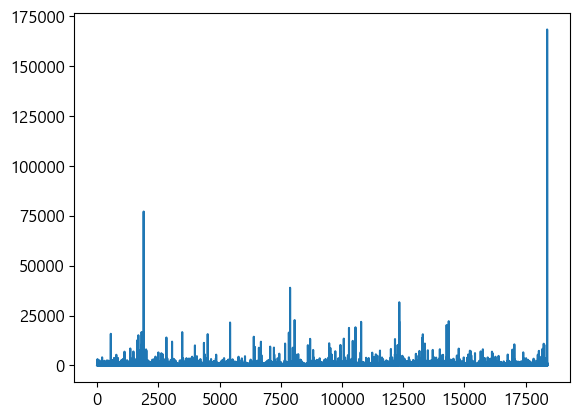

In [155]:
# 파생 변수 생성 - 계산된 필드 추가
# 수량, 합계 등 자주 사용하는 데이터는 미리 연산을 해서
# 파생 변수로 만들어 놓고 사용하는게 더 좋을 수 있음
df['amount'] = df['Quantity'] * df['UnitPrice']

# 물품별 거래 금액
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)

In [157]:
# 데이터를 특정 시점을 기준으로 분리 - 2011년 7월 1일을 기준으로
import datetime

df_year_round = df[df['date'] < datetime.date(2011, 7, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 7, 1)]
print(df_year_round.head())
print(df_year_end.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  ContainDigit  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom          True   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom          True   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   

         date  amount  
0  2010-12-01   15.30  
1  2010-12-01   20.34  
2  2010-12-01   22.00  
3  2010-

In [158]:
# 7월 이전 데이터에서 유저 id 별로 상품 id 가 하나씩만 존재하도록 수정
# 데이터를 가져오고 set 을 적용해서 중복되는 데이터 제거
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {22212, 23171, 22725, 84625C, 85232D, 22772, 2...
12348    {21977, 21980, 21726, 84988, 22951, 84992, 219...
12350    {22348, 21832, 20615, 22557, 22620, 21864, 211...
12352    {22646, 22853, 22645, 21754, 22701, 22779, 221...
                               ...                        
18273                                             {79302M}
18280    {22499, 22358, 22467, 22180, 22725, 22084, 224...
18281    {22037, 22028, 22467, 23209, 23008, 22716, 23007}
18283    {20726, 22747, 22352, 22645, 21828, 20969, 220...
18287    {22756, 85040A, 47421, 85039B, 22757, 22582, 2...
Name: StockCode, Length: 2958, dtype: object


In [160]:
# 7월 이전에 구매한 상품 코드를 이후에 구매한 상품의 코드와 구분하기 위해
# 코드 이름에 old 를 추가
# 고객 아이디별로 구매한 상품을 dict 로 생성

customer_item_dict = {}
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    
    for stock in stocks:
        customer_item_dict[customer_id][stock] = 'old'

print(str(customer_item_dict)[:100])

{'12346': {'23166': 'old'}, '12347': {'22212': 'old', '23171': 'old', '22725': 'old', '84625C': 'old


In [167]:
# 7월 이후에 구매한 상품에 대해서도 중복을 제거
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
#print(customer_item_end_set)

# 7월 이전에만 구매한 상품은 old, 이후에만 구매한 상품은 new
# 양 쪽 기간 모두 구매한 상품은 both 를 value 로 추가
# both 처럼 반복적으로 구매한 상품은 주기를 파악할 필요가 있음
for customer_id, stocks in customer_item_end_set.items():
    # 7월 이전에 구매한 물품에 포함되는지 확인이 필요함
    # customer_item_dict 는 customer_id 를 key로 가지고 
    #구매한 상품을 dict 로 가지고 있음
    if customer_id in customer_item_dict:
        for stock in stocks:
            if stock in customer_item_dict[customer_id]:
                # 이전 구매 기록과 겹치면 both 로 수정
                customer_item_dict[customer_id][stock] = 'both'
            else:
                customer_item_dict[customer_id][stock] = 'new'
                
        
    # 이 경우에는 이전에 구매한 기록이 없는 유저이므로
    # 이전에 구매한 물품인지 확인할 필요가 없음
    else:
        customer_item_dict[customer_id] = {}
        for stock in stocks:
            
            customer_item_dict[customer_id][stock] = 'new'
            
# 결과 확인            
print(str(customer_item_dict)[:150])
print(str(customer_item_dict)[-150:])
# customer_item_dict 에 old 뿐만 아니라 both 도 생김
        

{'12346': {'23166': 'old'}, '12347': {'22212': 'old', '23171': 'old', '22725': 'both', '84625C': 'old', '85232D': 'old', '22772': 'old', '22773': 'old
424': 'both', '21270': 'both', '23295': 'both', '22699': 'both', '23175': 'both', '21108': 'both', '23187': 'both', '22089': 'both', '23174': 'both'}}


In [185]:
# 고객 별로 old, new, both 의 갯수를 파악
# both 가 있다면 계속 물품을 구매한다는 의미

# 데이터를 저장할 DataFrame 을 새로 생성
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns = columns)

for customer_id in customer_item_dict:
    old, new, both = 0, 0, 0
    
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        
        if status == 'old':
            old += 1
        if status == 'new':
            new += 1
        else:
            both += 1
    
    # DataFrane 에 갯수를 추가
    row = [customer_id, old, new, both]
    # 데이터를 Series 로 만들고 
    series = pd.Series(row, index = columns)
    df_order_info = df_order_info.append(series, ignore_index = True)
    #df_order_info = pd.concat([df_order_info, series], ignore_index = True)
    
    
#print(df_order_info.head())
            

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6664\817479978.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

In [173]:
print(df_order_info.head())

  CustomerID old new both
0      12346   1   0    1
1      12347  44   0  103
2      12348  19   0   21
3      12350  16   0   16
4      12352  19   0   57


In [180]:
# 전체 사용자 수
print(df_order_info.shape[0])

# 7월 이후에 새로운 상품을 구매한 사용자의 수
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

# 7월 이후에 동일한 제품을 재구매한 고객의 수
# 이 고객들의 경우 구매 주기를 확인해 볼 필요가 있음
# 식료품의 경우 미리 알림을 주는 것도 마케팅 방법 중 하나
# 동일한 식료품이면서 품질이 더 좋거나 싼 제품을 추천하는 것도 방법
print(df_order_info[df_order_info['both'] > 0].shape[0])

4335
0
4335


In [189]:
# 7월 이후에 어떤 상품을 많이 새로 구매했는지 확인
# 각 연도별 원 단위로도 체크를 해야 함
# 이전 몇 개월 동안 구매하지 않다가 특정 달에 구매하는 경우는 계절성 상품
print(df_order_info['new'].value_counts())

0    4335
Name: new, dtype: int64
0      1412
5        87
1        85
8        84
11       80
       ... 
180       1
387       1
185       1
119       1
140       1
Name: old, Length: 182, dtype: int64


In [191]:
# 유저의 수와 상품의 수 파악

# 유저의 수
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_end['CustomerID'].unique()))
# 상품의 수
print(len(df_year_round['StockCode'].unique()))
print(len(df_year_end['StockCode'].unique()))


2958
3361
3267
3182


In [192]:
# 추천 시스템을 만들 때는 유저와 상품, 평점이 존재해야 함
# 쇼핑몰의 경우 평점 대신에 구매 횟수를 사용하기도 함

# 유저 id와 물품 번호 별 구매 횟수 데이터 가져오기
# 데이터를 합치는 경우 인덱스가 겹칠 수 있기 때문에
# 이를 방지하고자 reset_index() 를 사용 - index 를 없애고 새로 만듬
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
print(uir_df.head())

  CustomerID StockCode  InvoiceNo
0      12346     23166          1
1      12347     16008          1
2      12347     17021          1
3      12347     20665          1
4      12347     20719          1


array([[<Axes: title={'center': 'InvoiceNo'}>]], dtype=object)

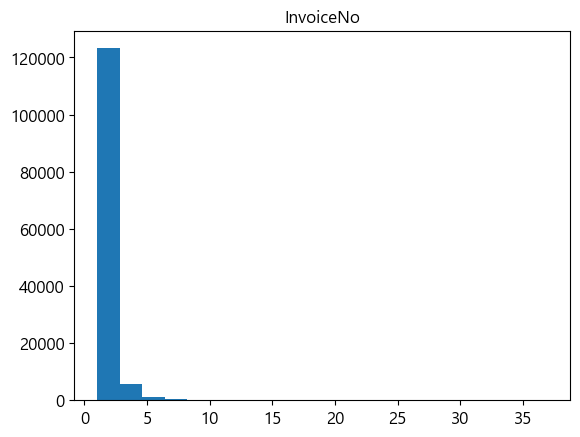

In [193]:
# 구매 횟수의 분포를 확인 - 구매의 경우 대부분 1번
# 예측을 할 때 타겟은 정규 분포를 따르는 경우 가장 잘 수행
# 타겟 값의 편차가 너무 크거나 한 쪽에 쏠린 경우 
# 로그 변환 등을 수행

# 히스토그램 사용
uir_df.hist(bins = 20, grid = False)

<Axes: >

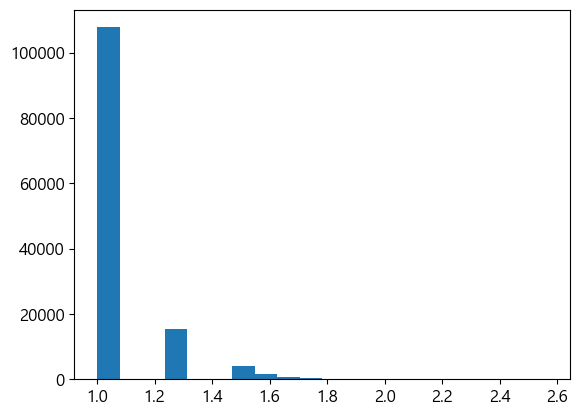

In [195]:
# 로그 변환을 수행
# 이후 히스토그램을 그려서 확인
uir_df['InvoiceNo'].apply(lambda x : np.log10(x) + 1).hist(bins = 20, grid = False)

In [203]:
# 로그 변환을 수행
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x : np.log10(x) + 1)
# min/max scaler 를 적용
# 최대와 최소 값을 가지고 0 ~ 1 사이의 범위로 변환한 다음
# 4를 곱하고 1을 더해서 1 ~ 5 사이의 값으로 만듦
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1

print(uir_df['Rating'].head())

1.0
2.568201724066995
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Rating, dtype: float64
1.0
5.0


In [205]:
# 추천 알고리즘이 사용할 데이터 생성

# uir_df 데이터에서 필요 없는 부분 제외
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
print(uir_df.head())

  CustomerID StockCode  Rating
0      12346     23166     1.0
1      12347     16008     1.0
2      12347     17021     1.0
3      12347     20665     1.0
4      12347     20719     1.0


In [208]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# 평점의 범위를 rating_scale 을 통해 지정
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size = 0.2,
                                        random_state = 21)

In [210]:
start_time = time.time()

# n_factors 는 주성분의 갯수로 기본값은 100
# lr_all 은 학습률
# reg_all 은 정규화 항으로 값이 클수록 파라미터를 작게 추정하는데
# 기본값은 0.02
# n_epochs 는 수행 횟수
model = SVD(n_factors = 8, lr_all = 0.005, reg_all = 0.02,
           n_epochs = 200)
model.fit(train_data)

end_time = time.time()

train_time = round(end_time - start_time, 3)
print('훈련 시간 :', train_time)

훈련 시간 : 2.703


In [211]:
# 예측
preds = model.test(test_data)
print(accuracy.rmse(preds))

RMSE: 0.3606
0.3605648582274705


In [212]:
print(str(preds)[:150])
# 예측 결과를 list 로 저장
# list에서 iid 가 추천할 item 의 id

[Prediction(uid='12748', iid='22798', r_ui=1.767834880026241, est=1.1295543154614234, details={'was_impossible': False}), Prediction(uid='15426', iid=


In [213]:
# 전체 데이터를 사용한 훈련

reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)

# train_test_split 이 아니라 전체 데이터를 사용
# train_data 는 내부적으로 2개의 함수를 이용해서 이전에 구매했던 제품과
# 이전에 구매하지 않았던 제품을 구분할 수 있음
# 이전에 구매하지 않았던 데이터는 biild_anti_testset()
# 이전에 구매했던 데이터는 build_testset() 를 통해 사용 가능
train_data = data.build_full_trainset()

start_time = time.time()

model = SVD(n_factors = 8, lr_all = 0.005, reg_all = 0.02,
           n_epochs = 200)
model.fit(train_data)

end_time = time.time()

train_time = round(end_time - start_time, 3)
print('훈련 시간 :', train_time)

훈련 시간 : 2.109


In [216]:
# 이전에 구매하지 않았던 데이터를 가지고 예측
# 이전에 했던 '보지 않은 영화 중에 추천하는 기능'을 포함하고 있음
test_data = train_data.build_anti_testset()
target_user_preds = model.test(test_data)
print(target_user_preds)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [218]:
# 구매 예측 결과를 dict 로 변환해서 보기 좋게 출력

new_order_prediction_dict = {}

# 기존에 존재하던 customer_id 이고 stock_code 가 있으면 pass
# stock_code 가 없던 코드이면 예측 평점을 추가
# 없던 customer_id 이면 새로 dict 를 생성하고 추가
for customer_id, stock_code, _, predicted_rating, _ in target_user_preds:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(new_order_prediction_dict)[:200] + '...')

{'12346': {'16008': 1.0059456679284622, '17021': 1.2111127767125158, '20665': 1.111958984351323, '20719': 1.2793180195860012, '20780': 1.0818825224687874, '20782': 1.2977644145134932, '20966': 1.09450...


In [220]:
# 이전에 구매했던 데이터를 가지고 예측
# anti 를 제외하고 build_testset() 을 사용

test_data = train_data.build_testset()
target_user_preds = model.test(test_data)
print(target_user_preds)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [221]:
# 위와 동일한 과정
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_preds:
    if customer_id in reorder_prediction _dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:200] + '...')

{'12346': {'23166': 1.009928270503747}, '12347': {'16008': 1.1713171257406432, '17021': 1.2251169548923002, '20665': 1.190740230576294, '20719': 1.1203843495458354, '20780': 1.2151306822971029, '20782...
